# Final Project (Part 02) - Animal Face Classifier (Multi-class CNN Image Classifier with Pytorch)

## Import

In [4]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno
from google.colab import drive
from google.colab import files

# Imports for metrics and plotting
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

print(f'PyTorch Version: {torch.__version__}')

PyTorch Version: 2.6.0+cu124


## Class Architecture

In [5]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

## Load Dataset

In [6]:
# Mounting Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Upload Kaggle API token (kaggle.json)
print("Upload 'kaggle.json' file:")

files.upload()

In [5]:
# Setup Kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download Kaggle Dataset
# The name of the dataset in the API is 'andrewmvd/animal-faces'
!kaggle datasets download -d andrewmvd/animal-faces --force

# Unzip the zipped file into the 'data' directory
!unzip -q animal-faces.zip -d ./data/

print("\nDataset successfully downloaded and unzipped into './data/' folder.")

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 95% 658M/696M [00:00<00:00, 1.37GB/s]
100% 696M/696M [00:00<00:00, 1.36GB/s]

Dataset successfully downloaded and unzipped into './data/' folder.


## Model Definitions

Here we define the classes for our three different CNN architectures.

In [7]:
# Base Model with 2 convolutional blocks for 28x28 images
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 3)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature@13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        # Note: No dropout is typically applied on the final output layer
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Base Model with 3 convolutional blocks for 28x28 images
class CNN3(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN3, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        # Creates the linear layers
        # Input dimension is n_feature * 1 * 1 after three pooling layers
        self.fc1 = nn.Linear(n_feature * 1 * 1, 50)
        self.fc2 = nn.Linear(50, 3)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block: 3@28x28 -> n_feature@13x13
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        # Second convolutional block: n_feature@13x13 -> n_feature@5x5
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        # Third convolutional block: n_feature@5x5 -> n_feature@1x1
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2)
        # Flatten the output
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 1 * 1) -> Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50) -> Output dimension (3)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# My Model with 3 convolutional blocks for 96x96 images
class CNN_96(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN_96, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        # Creates the linear layers
        # Input dimension is n_feature * 10 * 10 after three pooling layers from 96x96
        self.fc1 = nn.Linear(n_feature * 10 * 10, 50)
        self.fc2 = nn.Linear(50, 3)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block: 3@96x96 -> n_feature@47x47
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        # Second convolutional block: n_feature@47x47 -> n_feature@22x22
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        # Third convolutional block: n_feature@22x22 -> n_feature@10x10
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2)
        # Flatten the output
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 10 * 10) -> Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50) -> Output dimension (3)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

print("Model architectures (CNN2, CNN3, CNN_96) defined with detailed comments.")

Model architectures (CNN2, CNN3, CNN_96) defined with detailed comments.


## Data Pre-processing for 96x96 Model

This is a dedicated pre-processing section for our final model, which uses larger images.

In [8]:
# Define data directories
train_dir = './data/afhq/train/'
val_dir = './data/afhq/val/'

In [9]:
# Data Pre-processing for 96x96 Model

# Temporary transform to calculate normalization stats for 96x96 images
temp_transform_96 = Compose([
    Resize((96, 96)),
    ToImage(),
    ToDtype(torch.float32, scale=True)
])
temp_train_dataset_96 = ImageFolder(root=train_dir, transform=temp_transform_96)
temp_loader_96 = DataLoader(temp_train_dataset_96, batch_size=32, num_workers=2)

# Calculate mean and std for 96x96 images
print("Calculating normalization statistics for 96x96 images...")
n_pixels_96 = len(temp_train_dataset_96) * 96 * 96
soma_96 = torch.zeros(3)
soma_quadrados_96 = torch.zeros(3)
for imagens, _ in temp_loader_96:
    soma_96 += imagens.sum(axis=[0, 2, 3])
    soma_quadrados_96 += (imagens ** 2).sum(axis=[0, 2, 3])

media_96 = soma_96 / n_pixels_96
desvio_padrao_96 = torch.sqrt((soma_quadrados_96 / n_pixels_96) - media_96 ** 2)
print("Calculation complete.")
print(f"Mean (96x96): {media_96}")
print(f"Std Dev (96x96): {desvio_padrao_96}")

# Final transform pipeline with new normalization
final_transform_96 = Compose([
    Resize((96, 96)),
    ToImage(),
    ToDtype(torch.float32, scale=True),
    Normalize(mean=media_96, std=desvio_padrao_96)
])

# Create final datasets and dataloaders for 96x96 model
train_dataset_96 = ImageFolder(root=train_dir, transform=final_transform_96)
val_dataset_96 = ImageFolder(root=val_dir, transform=final_transform_96)

train_loader_96 = DataLoader(train_dataset_96, batch_size=32, shuffle=True, num_workers=2)
val_loader_96 = DataLoader(val_dataset_96, batch_size=32, num_workers=2)

print(f"\nDataLoaders for 96x96 models are ready.")

Calculating normalization statistics for 96x96 images...
Calculation complete.
Mean (96x96): tensor([0.5022, 0.4599, 0.3994])
Std Dev (96x96): tensor([0.2457, 0.2359, 0.2410])

DataLoaders for 96x96 models are ready.


Displaying one sample image from each class (96x96 resolution)...


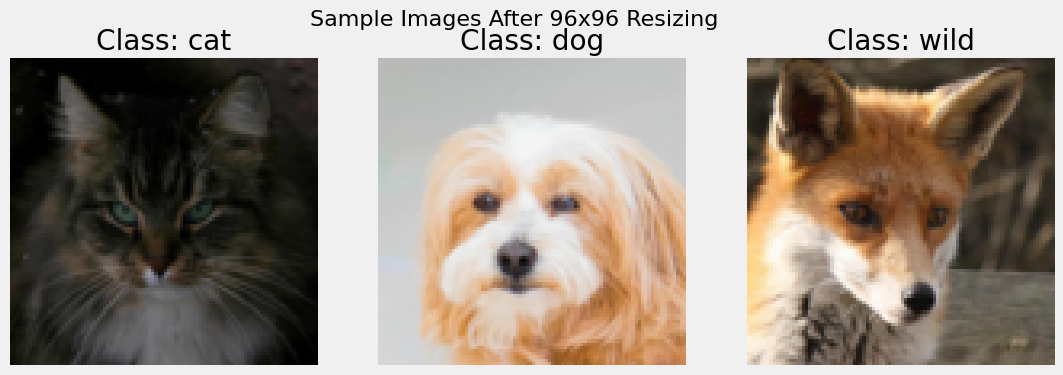

In [11]:
# Visualize 96x96 Images

print("Displaying one sample image from each class (96x96 resolution)...")

# Dictionary to store one image per class
images_to_plot_96 = {}
class_names_96 = temp_train_dataset_96.classes

# Iterate through the 96x96 dataset to find one sample for each class
for img, label in temp_train_dataset_96:
    if len(images_to_plot_96) == len(class_names_96):
        break  # Exit loop once we have one of each
    if label not in images_to_plot_96:
        images_to_plot_96[label] = img

# Create the figure for plotting
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Sample Images After 96x96 Resizing', fontsize=16)

# Plot each found image
for i, label in enumerate(sorted(images_to_plot_96.keys())):
    ax = axs[i]
    # Reorder tensor dimensions from (C, H, W) to (H, W, C) for plotting
    ax.imshow(images_to_plot_96[label].permute(1, 2, 0))
    ax.set_title(f'Class: {class_names_96[label]}')
    ax.axis('off')

plt.show()

## Finding LR

Here we gonna use LRFindings to find best Learnig Rate for trainig My model again and check if we catch acuraccy improvement.

In [10]:
# --- 1. Install the torch-lr-finder library ---
!pip install -q torch-lr-finder

In [11]:
# --- 2. Run the Learning Rate Range Test ---

from torch_lr_finder import LRFinder

Setting up the Learning Rate Range Test using 'torch-lr-finder'...
Running LR Range Test...


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.96E-03


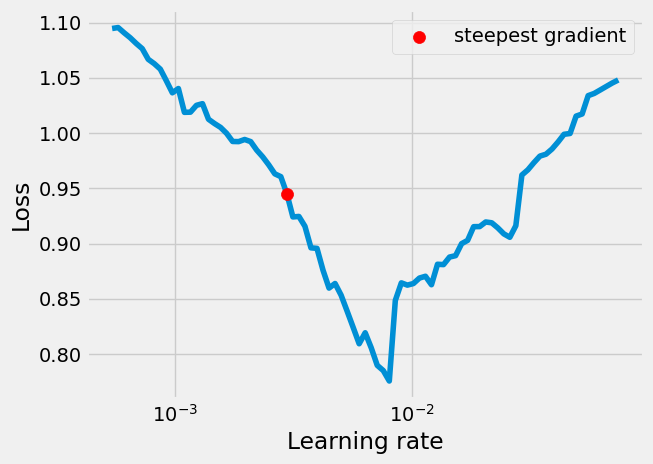


LR Range Test Finished.


In [12]:
print("Setting up the Learning Rate Range Test using 'torch-lr-finder'...")

# 1. Instantiate a fresh model, optimizer, and loss function
#    It's crucial to start with an un-trained model.
torch.manual_seed(42)
model_for_lr_find = CNN_96(n_feature=64, p=0.5)
loss_fn_for_lr_find = nn.CrossEntropyLoss()
optimizer_for_lr_find = optim.Adam(model_for_lr_find.parameters(), lr=3e-4)

# 2. Instantiate the LRFinder from the library
#    The model should be moved to the correct device BEFORE creating the finder.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_for_lr_find.to(device)
lr_finder = LRFinder(model_for_lr_find, optimizer_for_lr_find, loss_fn_for_lr_find, device=device)

# 3. Run the range test
#    This will iterate through learning rates from 1e-7 to 10.
print("Running LR Range Test...")
lr_finder.range_test(train_loader_96, end_lr=1e-1, num_iter=100, step_mode="exp")

# 4. Plot the results to find the optimal learning rate
lr_finder.plot()

# 5. Reset the model and optimizer to their initial state
lr_finder.reset()
print("\nLR Range Test Finished.")

## Experiment 5 - My Model v2 with new learning rate (LR)

*   **Architecture:** CNN3_96
*   **Features:** 64
*   **Dropout:** 0.5
*   **Image Size:** 96x96


Setting up Experiment 5: My Model v2 with new LR
Trainable parameters for My Model v2: 395,851
Training Started
Training Finished


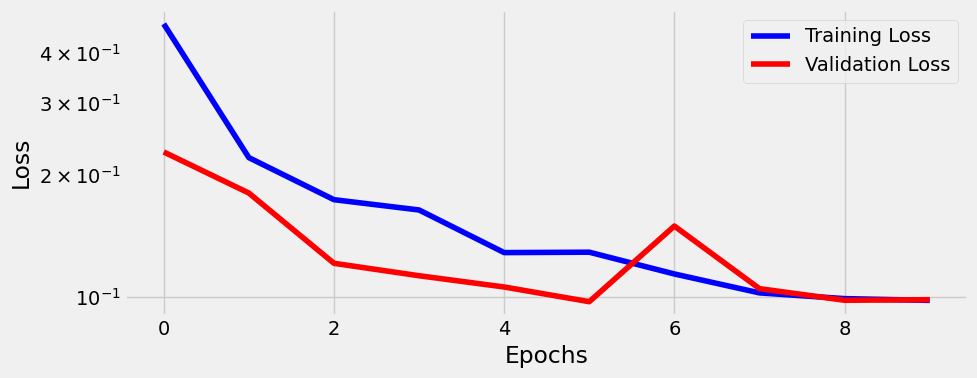

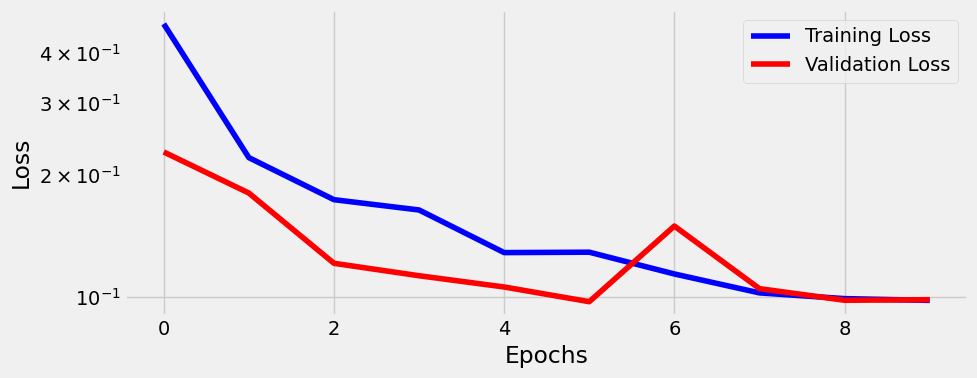

In [13]:
# Experiment 5: My Model v2 with new LR (CNN_96, 64 features, 96x96)

print("\nSetting up Experiment 5: My Model v2 with new LR")
torch.manual_seed(42)

# Model/Architecture
model_v2 = CNN_96(n_feature=64, p=0.5)
# Loss Function
loss_fn_v2 = nn.CrossEntropyLoss()
# Optimizer
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=2.96e-3)

# Print the number of trainable parameters
print(f"Trainable parameters for My Model v2: {sum(p.numel() for p in model_v2.parameters() if p.requires_grad):,}")

# Wraps the model, loss function, and optimizer
arch_v2 = Architecture(model_v2, loss_fn_v2, optimizer_v2)
# Sets the data loaders for 96x96 images
arch_v2.set_loaders(train_loader_96, val_loader_96)

# Train the model
print("Training Started")
arch_v2.train(n_epochs=10)
print("Training Finished")

# Plots the training and validation losses
arch_v2.plot_losses()



Evaluating My Model v2 with new LR...
Overall Accuracy: 97.47%

Classification Report
              precision    recall  f1-score   support

         cat       0.98      0.98      0.98       500
         dog       0.99      0.95      0.97       500
        wild       0.96      0.99      0.97       500

    accuracy                           0.97      1500
   macro avg       0.98      0.97      0.97      1500
weighted avg       0.98      0.97      0.97      1500

Confusion Matrix


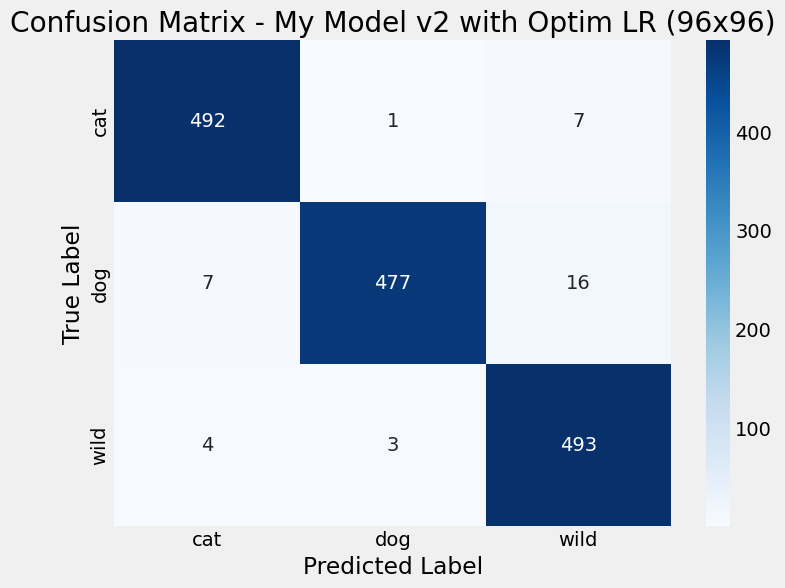

In [18]:
# My Model v2 with new LR Evaluation

# Select the model and dataloader to evaluate
# For Experiment 5 (My Model v2)
model_to_evaluate = model_v2
dataloader_to_evaluate = val_loader_96
architecture_object = arch_v2
# ----------------------------------------------------

print("\nEvaluating My Model v2 with new LR...")

all_preds = []
all_labels = []

# Set model to evaluation mode
model_to_evaluate.eval()
with torch.no_grad():
    for images, labels in dataloader_to_evaluate:
        # Move data to the same device as the model
        images = images.to(architecture_object.device)

        # Get model predictions
        outputs = model_to_evaluate(images)
        _, predicted = torch.max(outputs, 1)

        # Collect predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get class names from the dataset
class_names = dataloader_to_evaluate.dataset.classes

# --- Print Metrics and Plot Confusion Matrix ---

# 1. Print Overall Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {accuracy * 100:.2f}%\n")

# 2. Print Classification Report (Precision, Recall, F1-Score)
print("Classification Report")
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

# 3. Generate and Plot Confusion Matrix
print("Confusion Matrix")
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix - My Model v2 with Optim LR (96x96)")
plt.show()

In [16]:
# Save Trained Model (My Model v2)

# Define the directory in your Google Drive to save the model.
save_dir = '/content/drive/MyDrive/_MESTRADO/ufrn-machine-learning/ufrn-animal-face-classifier/model/'

# Create the directory if it does not exist.
os.makedirs(save_dir, exist_ok=True)

# Define the filename for the User's Model v2.
file_name = 'user_model_v2_96x96_with_LR.pth'
full_path = os.path.join(save_dir, file_name)

# Save the model's state dictionary.
# 'model_v2' is the variable holding your trained model.
torch.save(model_v2.state_dict(), full_path)

print(f"\nMy Model v2 with new LR saved successfully to: {full_path}")


My Model v2 with new LR saved successfully to: /content/drive/MyDrive/_MESTRADO/ufrn-machine-learning/ufrn-animal-face-classifier/model/user_model_v2_96x96_with_LR.pth


## Hooks - Experimenter 5

In [17]:
#    Recreate the model's architecture
print("Recreating the model architecture...")
loaded_model = CNN_96(n_feature=64, p=0.5)

# Define the path to your saved model file
model_path = '/content/drive/MyDrive/_MESTRADO/ufrn-machine-learning/ufrn-animal-face-classifier/model/user_model_v2_96x96_with_LR.pth'

# Load the saved weights into the model instance
print(f"Loading saved weights from: {model_path}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
loaded_model.to(device)

# --- Now, run the hook inspection on the loaded model ---
dummy_optimizer = torch.optim.Adam(loaded_model.parameters())
dummy_loss_fn = torch.nn.CrossEntropyLoss()
arch_loaded_model = Architecture(loaded_model, dummy_loss_fn, dummy_optimizer)
arch_loaded_model.set_loaders(train_loader_96, val_loader_96) # Set the correct loader

print("\nSetting up hooks to visualize feature maps...")
featurizer_layers_to_inspect = ['conv1', 'conv2', 'conv3']
arch_loaded_model.attach_hooks(layers_to_hook=featurizer_layers_to_inspect)

# Get a single batch of data from the validation loader
images_batch, _ = next(iter(val_loader_96))

# Pass the batch through the loaded model to trigger the hooks
with torch.no_grad():
    loaded_model.eval() # Set to evaluation mode
    _ = loaded_model(images_batch.to(device))

# Visualize the captured feature maps
print("Plotting feature maps from hooked layers...")
fig_hooks_loaded = arch_loaded_model.visualize_outputs(featurizer_layers_to_inspect)
plt.show()

# Clean up by removing the hooks
arch_loaded_model.remove_hooks()
print("\nHooks removed successfully.")

Output hidden; open in https://colab.research.google.com to view.